In [1]:
# Training variables
rolling_mean = 30

## Import data from AWS S3

In [2]:
import sys
sys.path.insert(0, '/home/khiem/Dropbox/Education/Drexel/DSCI-591/Project/Walmart-Strategic-Sales-Forecasting')

In [3]:
import boto3
import pandas as pd

bucket = 'dsci-632'

s3 = boto3.client('s3')
obj = s3.get_object(Bucket="dsci-632", Key="CA_1_sales_data.csv")
df = pd.read_csv(obj['Body'], index_col=0, parse_dates=True) # 'Body' is a keyword
print(df.head())

            wm_yr_wk  wday  month  year event_name_1 event_type_1  \
2011-01-29     11101     1      1  2011         None         None   
2011-01-30     11101     2      1  2011         None         None   
2011-01-31     11101     3      1  2011         None         None   
2011-02-01     11101     4      2  2011         None         None   
2011-02-02     11101     5      2  2011         None         None   

           event_name_2 event_type_2      cpi  unemployment_rate  gas_price  \
2011-01-29         None         None  221.187                9.1      3.163   
2011-01-30         None         None  221.187                9.1      3.163   
2011-01-31         None         None  221.187                9.1      3.155   
2011-02-01         None         None  221.898                9.0      3.155   
2011-02-02         None         None  221.898                9.0      3.155   

            snap_ca  ca_walmart  ca_hobbies  ca_household  ca_foods  \
2011-01-29        0       39.50       2

## Data Processing

1912


/home/khiem/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


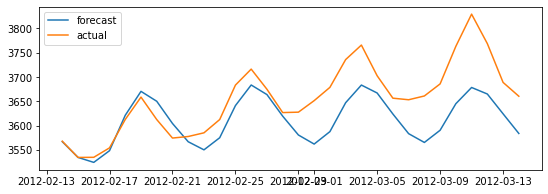

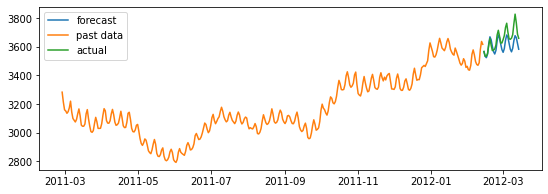

MSE: 4148.829919347686
RMSE: 64.41141140626935
R2: 0.19588896929760913
WAPE: -0.012094371961873575
WMAPE: 0.013723720902162109


/home/khiem/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


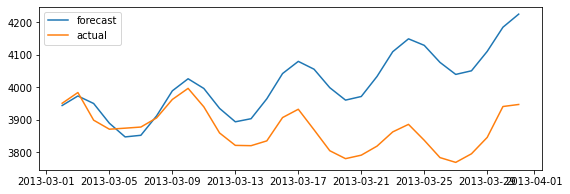

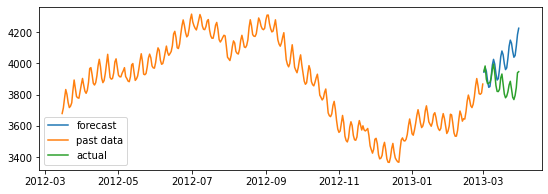

MSE: 30534.56598480394
RMSE: 174.74142606950403
R2: -6.634201676955144
WAPE: 0.035785954301777
WMAPE: 0.03697901726080334


/home/khiem/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


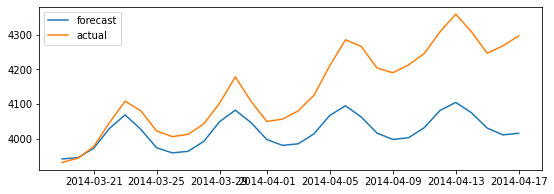

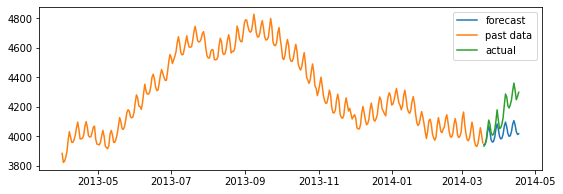

MSE: 22768.105189170696
RMSE: 150.89103747131801
R2: -0.6101928549165483
WAPE: -0.028838080392339236
WMAPE: 0.02903297939812174


/home/khiem/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


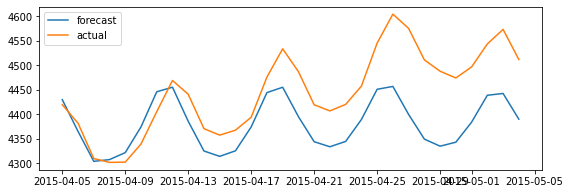

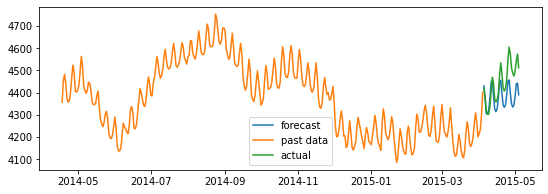

MSE: 7786.340020832188
RMSE: 88.2402403715685
R2: -0.1402234182888138
WAPE: -0.014481675765274711
WMAPE: 0.016175284323325812


/home/khiem/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


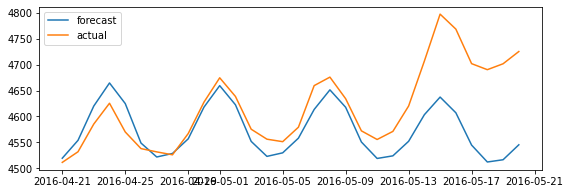

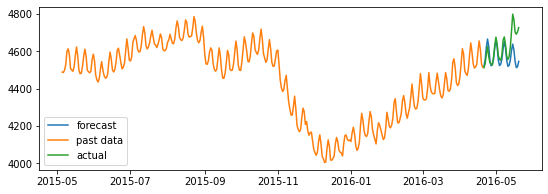

MSE: 6934.035572124876
RMSE: 83.27085667942222
R2: -0.22094790164249467
WAPE: -0.009757234533237428
WMAPE: 0.012271160515075152
----------
MSE: 14434.375337255877
RMSE: 112.31099439961642
R2: -1.4819353765010785
WAPE: -0.005877081670189589
WMAPE: 0.02163643247989763


In [4]:
from data_processing.pre_modeling import pre_modeling
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

df_processed = pre_modeling(df)

timeseries_cols = ['cpi', 'unemployment_rate', 'gas_price', 'ca_walmart', 'ca_hobbies', 'ca_household', 'ca_foods', 'median_price', 'min_price', 'max_price']
time_cols = ['wm_yr_wk', 'wday', 'day', 'month', 'year']
target_col = ['store_sales']
cat_cols = [col for col in df_processed.columns if col not in timeseries_cols + time_cols + target_col]

df_processed = df_processed.rolling(rolling_mean).mean().dropna()
df_used = df_processed[timeseries_cols+target_col]

class BlockingTimeSeriesSplit():
    def __init__(self, n_splits, test_size = -1):
        self.n_splits = n_splits
        self.test_size = test_size
    
    def get_n_splits(self):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        print(n_samples)
        k_fold_size = n_samples // self.n_splits
        indices = X.index

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            if self.test_size > 0:
                mid = stop - self.test_size
            else:
                mid = int(0.5 * (stop - start)) + start
            yield X[start: mid], X[mid + margin: stop]
            
def invert_transformation(df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

nobs = 30
tscv = BlockingTimeSeriesSplit(n_splits=5, test_size=nobs)

error_mse_list = []
error_rmse_list = []
error_r2_list = []
wape_list = []
wmape_list = []

for df_used_train_org, df_used_test in tscv.split(df_used):
    df_used_train = df_used_train_org.diff().dropna()
    model = VAR(df_used_train)
    model_fitted = model.fit(7)
    lag_order = model_fitted.k_ar
    forecast_input = df_used_train.values[-lag_order:]
    fc = model_fitted.forecast(y=forecast_input, steps=nobs)
    df_forecast = pd.DataFrame(fc, index=df_used_test.index, columns=df_used_test.columns + '_1d')
    df_results = invert_transformation(df_used_train_org, df_forecast)

    plt.figure(figsize=(9, 3))
    plt.plot(df_results.index, df_results["store_sales_forecast"], label = "forecast")
    plt.plot(df_used_test.index, df_used_test["store_sales"], label = "actual")
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(9, 3))
    plt.plot(df_results.index, df_results["store_sales_forecast"], label = "forecast")
    plt.plot(df_used_train_org.index, df_used_train_org["store_sales"], label = "past data")
    plt.plot(df_used_test.index, df_used_test["store_sales"], label = "actual")
    plt.legend()
    plt.show()
    
    error_mse = mean_squared_error(df_used_test["store_sales"], df_results["store_sales_forecast"])
    error_rmse = np.sqrt(error_mse)
    error_r2 = r2_score(df_used_test["store_sales"], df_results["store_sales_forecast"])
    print("MSE:", error_mse)
    print("RMSE:", error_rmse)
    print("R2:", error_r2)
    # Weighted average percentage error
    wape = ((df_results["store_sales_forecast"] - df_used_test["store_sales"]) / df_used_test["store_sales"]).mean() 
    print("WAPE:", wape)
    # Weighted Mean Absolute Percentage Error
    wmape = np.abs((df_results["store_sales_forecast"] - df_used_test["store_sales"]) / df_used_test["store_sales"]).mean()
    print("WMAPE:", wmape)

    error_mse_list.append(error_mse)
    error_rmse_list.append(error_rmse)
    error_r2_list.append(error_r2)
    wape_list.append(wape)
    wmape_list.append(wmape)
    

print("----------")
print("MSE:", np.mean(error_mse_list))
print("RMSE:", np.mean(error_rmse_list))
print("R2:", np.mean(error_r2_list))
print("WAPE:", np.mean(wape_list))
print("WMAPE:", np.mean(wmape_list))
